<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Embedding-с-помощью-toxicBERT" data-toc-modified-id="Embedding-с-помощью-toxicBERT-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Embedding с помощью toxicBERT</a></span></li><li><span><a href="#TF-IDF-признаки" data-toc-modified-id="TF-IDF-признаки-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><em>TF-IDF</em> признаки</a></span></li><li><span><a href="#Борьба-с-несбалансированностью-классов" data-toc-modified-id="Борьба-с-несбалансированностью-классов-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Борьба с несбалансированностью классов</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Обучение-да-признаках-BERT" data-toc-modified-id="Обучение-да-признаках-BERT-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучение да признаках BERT</a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoost-Classifier" data-toc-modified-id="CatBoost-Classifier-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>CatBoost Classifier</a></span></li></ul></li><li><span><a href="#Обучение-на-признаках-TF-IDF" data-toc-modified-id="Обучение-на-признаках-TF-IDF-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение на признаках <em>TF-IDF</em></a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoost-Classifier" data-toc-modified-id="CatBoost-Classifier-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>CatBoost Classifier</a></span></li><li><span><a href="#BernoulliNB" data-toc-modified-id="BernoulliNB-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>BernoulliNB</a></span></li></ul></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Антитоксичная модель

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. <br>

Необходимо научить модель классифицировать комментарии на позитивные и негативные. В распоряжении имеется набор данных (тексты на английском языке) с разметкой о токсичности правок. <br>

Значением метрики качества F1 должно быть не меньше 0.75.

In [1]:
import numpy as np
import pandas as pd
import tensorflow
import re
import torch
import matplotlib.pyplot as plt

import transformers
from transformers import DistilBertConfig, DistilBertModel, DistilBertTokenizer

from tqdm import notebook

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.naive_bayes import BernoulliNB
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

In [2]:
STATE = np.random.RandomState(12345)

## Загрузка и подготовка данных

Для начала загрузим и посмотрим на данные.

In [3]:
data = pd.read_csv('toxic_comments.csv', index_col=0)
print(data.shape)
display(data.head())
data.info()

(159292, 2)


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


В нашем распоряжении имеется достаточно большой объем данных (159 тысяч строк и два столбца). Пустых значений нет. <br>
В столбце *text* представлены твиты на английском языке, а в *toxic* - является твит "токсичным". <br>
Далее нам стоит очистить текст для дальнейшей работы с ним.

In [4]:
# Функция для очистки текста
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text).split()
    clear_text = ' '.join(clear_text)
    return(clear_text)

In [5]:
# Функция для приведения слов текста к "лемме"
wnl = WordNetLemmatizer()

def lemmatize(text):
    text = text.lower()
    text = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(word_tokenize(text))]
    text = ' '.join(text)
    return text

Также в дальнейшем мы отберем не слишком длинные твиты, поэтому удет полезно знать количество слов в строках текста.

In [6]:
def cut(tweet):
    return len(tweet.split())

Очистим текст

In [7]:
data['text'] = data['text'].apply(clear_text)

Также проверим на дубликаты и, если обнаружим их, удалим.

In [8]:
data.duplicated().sum()

1148

In [9]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

Теперь добавим столбец с количеством слов для удобства.

In [10]:
data['n_words'] = data['text'].apply(cut)

Для анализа возьмем твиты длиной не более 60 слов. Это уменьшит вычислительную мощность, необходимую на преобразование в признаки.

In [11]:
data = data.query('n_words <= 60')
data = data.drop('n_words', axis=1)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107475 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    107475 non-null  object
 1   toxic   107475 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


0    0.881182
1    0.118818
Name: toxic, dtype: float64


<AxesSubplot:>

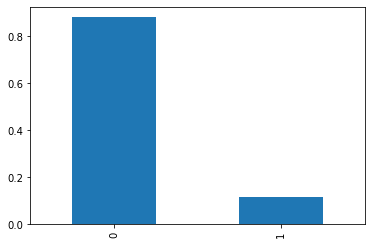

In [13]:
class_frequency = data['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Итак, мы имеем несбалансированную классификацию. Мы умеем с ней бороться, чем мы и займемся позже. <br>
Сейчас - разделение на тестовую и тренировочную выборки в соотношении 2:8 соответственно.

В исходном датафрейме 150 000 строк. Их обработка требует значительных мощностей, поэтому возьмем лишь часть данных.

0    0.8848
1    0.1152
Name: toxic, dtype: float64


<AxesSubplot:>

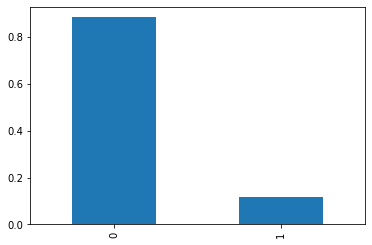

In [14]:
data = data.sample(10000).reset_index(drop=True)
class_frequency = data['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Настало время лемматизации!

In [15]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yuriy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yuriy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yuriy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
data['text_lem'] = data['text'].apply(lemmatize)

Посмотрим на получившийся фрейм данных.

In [17]:
data.head()

,text,toxic,text_lem
0,You should put the photo of Aristidh Kola for ...,0,you should put the photo of aristidh kola for ...
1,I am attempting to a dumping ground talk page ...,0,i be attempt to a dumping ground talk page her...
2,OK I understood now Thank you,0,ok i understand now thank you
3,I agree I just wanted to do the same revert be...,1,i agree i just want to do the same revert beca...
4,Explain how that argument was fallacious You a...,0,explain how that argument be fallacious you ar...


In [18]:
train, test = train_test_split(data, test_size=0.2, random_state=STATE)

features_train = train['text_lem'].reset_index(drop=True)
features_test = test['text_lem'].reset_index(drop=True)

target_train = train['toxic'].reset_index(drop=True)
target_test = test['toxic'].reset_index(drop=True)

### Embedding с помощью toxicBERT

Для получения признаков воспользуемся Бертом, обученном на английском языке.

In [19]:
def make_embeddings1(features):
    tokenizer = transformers.BertTokenizer(vocab_file='toxic_bert/vocab.txt')

    tokenized = features.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=60, truncation=True, padding=True))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

    attention_mask = np.where(padded != 0, 1, 0)

    config = transformers.BertConfig.from_json_file(
        'toxic_bert/config.json')
    model = transformers.BertModel.from_pretrained(
        'toxic_bert/pytorch_model.bin', config=config)

    batch_size = 100
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
            embeddings.append(batch_embeddings[0][:,0,:].numpy())
        
    features = np.concatenate(embeddings)
    features = pd.DataFrame(features)
    return features

Осталось только преобразовать признаки.

In [20]:
#features_train_bert = make_embeddings1(features_train)
#features_train_bert.to_csv('features_train_toxic_bert')
#target_train.to_csv('target_train_toxic_bert')

#features_test_bert = make_embeddings1(features_test)
#features_test_bert.to_csv('features_test_toxic_bert')
#target_test.to_csv('target_test_toxic_bert')

Потребовалось около 13 часов для того, чтобы обработать 10 000 строк. Получившиеся признаки были сохранены в формате csv для быстрого доступа к ним, и теперь в нашем распоряжении имеется множество данных для обучения.

In [21]:
features_train_bert = pd.read_csv('features_train_toxic_bert', index_col=0)
target_train_bert = pd.read_csv('target_train_toxic_bert', index_col=0)
target_train_bert = target_train_bert['toxic']

features_test_bert = pd.read_csv('features_test_toxic_bert', index_col=0)
target_test_bert = pd.read_csv('target_test_toxic_bert', index_col=0)
target_test_bert = target_test_bert['toxic']

In [22]:
print('Тренировочная выборка:', features_train_bert.shape, target_train_bert.shape)
print('Тестовая выборка выборка:', features_test_bert.shape, target_test_bert.shape)

Тренировочная выборка: (8000, 768) (8000,)
Тестовая выборка выборка: (2000, 768) (2000,)


Итого: у нас 768 признаков.

### *TF-IDF* признаки

In [23]:
corpus_train = features_train
corpus_test = features_test
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))
features_train_tf = count_tf_idf.fit_transform(corpus_train)
features_test_tf = count_tf_idf.transform(corpus_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yuriy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
features_train_tf = pd.DataFrame(features_train_tf.todense())
features_test_tf = pd.DataFrame(features_test_tf.todense())

In [25]:
print('Тренировочная выборка:', features_train_tf.shape, target_train.shape)
print('Тестовая выборка выборка:', features_test_tf.shape, target_test.shape)

Тренировочная выборка: (8000, 15210) (8000,)
Тестовая выборка выборка: (2000, 15210) (2000,)


### Борьба с несбалансированностью классов

In [26]:
oversample = SMOTE(random_state=STATE)
features_train_bert_up, target_train_bert_up = oversample.fit_resample(features_train_bert, target_train_bert)

In [27]:
oversample = SMOTE(random_state=STATE)
features_train_tf_up, target_train_tf_up = oversample.fit_resample(features_train_tf, target_train)

## Обучение моделей

### Обучение да признаках BERT

#### LightGBM

In [28]:
%%time

model_lgb = LGBMClassifier(random_state=STATE)

pipeline_lgb = make_pipeline(SMOTE(random_state=STATE), 
                              model_lgb)

param_grid_lgb = {
    'lgbmclassifier__max_depth': [9, 21, -1],
    'lgbmclassifier__min_data_in_leaf': [4, 5],
    'lgbmclassifier__num_leaves': [300, 500],
    'lgbmclassifier__n_estimators' : [500]
}

gs_lgb_bert = RandomizedSearchCV(
    pipeline_lgb, 
    param_distributions=param_grid_lgb, 
    scoring='f1', 
    n_jobs=-1,
    random_state=STATE
)

gs_lgb_bert.fit(features_train_bert, target_train_bert)

lgb_bert_score = gs_lgb_bert.best_score_
gs_lgb_bert_best_params = gs_lgb_bert.best_params_

# лучшее значение f1 на кросс-валидации
print(f'best_score: {lgb_bert_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_lgb_bert_best_params}')

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
best_score: 0.9174178947575886
best_params: {'lgbmclassifier__num_leaves': 500, 'lgbmclassifier__n_estimators': 500, 'lgbmclassifier__min_data_in_leaf': 5, 'lgbmclassifier__max_depth': -1}
Wall time: 15min 14s


#### RandomForestClassifier

In [29]:
%%time

model_rf = RandomForestClassifier(random_state=STATE)

pipeline_rf = make_pipeline(SMOTE(random_state=STATE), 
                              model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': [100, 300],
    'randomforestclassifier__max_depth': [5, 13, 27],
    'randomforestclassifier__min_samples_split': [2, 7, 13],
    'randomforestclassifier__min_samples_leaf': [2, 4, 6]
}

gs_rf_bert = RandomizedSearchCV(
    pipeline_rf, 
    param_distributions=param_grid_rf, 
    scoring='f1', 
    n_jobs=-1, 
    random_state=STATE
)

gs_rf_bert.fit(features_train_bert, target_train_bert)

rf_bert_score = gs_rf_bert.best_score_
gs_rf_bert_best_params = gs_rf_bert.best_params_
print(f'best_score: {rf_bert_score}')
print(f'best_params: {gs_rf_bert_best_params}')

best_score: 0.9152713186956118
best_params: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 7, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 13}
Wall time: 7min 40s


#### LogisticRegression

In [30]:
%%time

model_lr = LogisticRegression(random_state=STATE)

pipeline_lr = make_pipeline(SMOTE(random_state=STATE), 
                              model_lr)

param_grid_lr = {
    'logisticregression__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
    'logisticregression__max_iter' : [100, 200, 500],
    'logisticregression__C' : [0.01, 0.1, 1, 10, 100]
}

gs_lr_bert = GridSearchCV(
    pipeline_lr, 
    param_grid=param_grid_lr, 
    scoring='f1', 
    n_jobs=-1
)

gs_lr_bert.fit(features_train_bert, target_train_bert)

lr_bert_score = gs_lr_bert.best_score_
gs_lr_bert_best_params = gs_lr_bert.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {lr_bert_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_lr_bert_best_params}')

best_score: 0.8969694527225218
best_params: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 100, 'logisticregression__solver': 'lbfgs'}
Wall time: 11min 27s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### CatBoost Classifier

In [31]:
%%time

model_cat = CatBoostClassifier(verbose=False)

pipeline_cat = make_pipeline(SMOTE(random_state=STATE), 
                              model_cat)

param_grid_cat = {
    'catboostclassifier__learning_rate': [0.04, 0.1],
    'catboostclassifier__iterations' : [200, 500, 700],
    'catboostclassifier__custom_loss' : ['F1']
}

gs_cat_bert = GridSearchCV(
    pipeline_cat, 
    param_grid=param_grid_cat, 
    scoring='f1', 
    n_jobs=-1
)

gs_cat_bert.fit(features_train_bert, target_train_bert)

cat_bert_score = gs_cat_bert.best_score_
gs_cat_bert_best_params = gs_cat_bert.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {cat_bert_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_cat_bert_best_params}')

best_score: 0.9129548861963631
best_params: {'catboostclassifier__custom_loss': 'F1', 'catboostclassifier__iterations': 700, 'catboostclassifier__learning_rate': 0.1}
Wall time: 12min 10s


### Обучение на признаках *TF-IDF*

#### LightGBM

In [32]:
%%time

model_lgb = LGBMClassifier(random_state=STATE)

pipeline_lgb = make_pipeline(SMOTE(random_state=STATE), 
                              model_lgb)

param_grid_lgb = {
    'lgbmclassifier__max_depth': [7, 13, 30],
    'lgbmclassifier__min_data_in_leaf': [5],
    'lgbmclassifier__num_leaves': [500],
    'lgbmclassifier__n_estimators' : [400, 500, 600]
}


gs_lgb = GridSearchCV(
    pipeline_lgb,
    param_grid=param_grid_lgb, 
    scoring='f1', 
    n_jobs=-1
)

gs_lgb.fit(features_train_tf, target_train)

lgb_tf_score = gs_lgb.best_score_
gs_lgb_tf_best_params = gs_lgb.best_params_

# лучшее значение f1 на кросс-валидации
print(f'best_score: {lgb_tf_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_lgb_tf_best_params}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_s

best_score: 0.7422712058914505
best_params: {'lgbmclassifier__max_depth': 7, 'lgbmclassifier__min_data_in_leaf': 5, 'lgbmclassifier__n_estimators': 600, 'lgbmclassifier__num_leaves': 500}
Wall time: 9min 4s


#### RandomForestClassifier

In [33]:
%%time

model_rf = RandomForestClassifier(random_state=STATE)

pipeline_rf = make_pipeline(SMOTE(random_state=STATE), 
                              model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': [100, 300],
    'randomforestclassifier__max_depth': [5, 13, 27],
    'randomforestclassifier__min_samples_split': [5, 7, 10],
    'randomforestclassifier__min_samples_leaf': [3, 4]
}

gs_rf = RandomizedSearchCV(
    pipeline_rf, 
    param_distributions=param_grid_rf, 
    scoring='f1', 
    n_jobs=-1, 
    random_state=STATE
)

gs_rf.fit(features_train_tf, target_train)

rf_tf_score = gs_rf.best_score_
gs_rf_tf_best_params = gs_rf.best_params_
print(f'best_score: {rf_tf_score}')
print(f'best_params: {gs_rf_tf_best_params}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\ProgramData\A

best_score: 0.6700890823583701
best_params: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 27}
Wall time: 4min 45s


#### LogisticRegression

In [34]:
%%time

model_lr = LogisticRegression(random_state=STATE)

pipeline_lr = make_pipeline(SMOTE(random_state=STATE), 
                              model_lr)

param_grid_lr = {
    'logisticregression__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
    'logisticregression__max_iter' : [100, 200, 500],
    'logisticregression__C' : [0.01, 0.1, 1, 10, 100]
}

gs_lr = RandomizedSearchCV(
    pipeline_lr, 
    param_distributions=param_grid_lr, 
    scoring='f1', 
    n_jobs=-1
)

gs_lr.fit(features_train_tf, target_train)

lr_tf_score = gs_lr.best_score_
gs_lr_tf_best_params = gs_lr.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {lr_tf_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_lr_tf_best_params}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\ProgramData\A

best_score: 0.7209678347184215
best_params: {'logisticregression__solver': 'liblinear', 'logisticregression__max_iter': 500, 'logisticregression__C': 1}
Wall time: 12min 49s


#### CatBoost Classifier

In [35]:
%%time

model_cat = CatBoostClassifier(verbose=False)

pipeline_cat = make_pipeline(SMOTE(random_state=STATE), 
                              model_cat)

param_grid_cat = {
    'catboostclassifier__learning_rate': [0.03],
    'catboostclassifier__iterations' : [100, 300, 500, 700],
    'catboostclassifier__custom_loss' : ['F1']
}

gs_cat = GridSearchCV(
    pipeline_cat, 
    param_grid=param_grid_cat, 
    scoring='f1', 
    n_jobs=-1
)

gs_cat.fit(features_train_tf, target_train)

cat_tf_score = gs_cat.best_score_
gs_cat_tf_best_params = gs_cat.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {cat_tf_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_cat_tf_best_params}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\ProgramData\A

best_score: 0.7306365950030747
best_params: {'catboostclassifier__custom_loss': 'F1', 'catboostclassifier__iterations': 700, 'catboostclassifier__learning_rate': 0.03}
Wall time: 7min 4s


#### BernoulliNB

In [36]:
%%time

model_nb = BernoulliNB()

pipeline_nb = make_pipeline(SMOTE(random_state=STATE), 
                              model_nb)

param_grid_nb = {
    'bernoullinb__alpha': np.arange(0.9, 1.01, 0.01),
#    'bernoullinb__fit_prior' : [True, False],
#    'bernoullinb__force_alpha' : [True, False]
}

gs_nb = GridSearchCV(
    pipeline_nb, 
    param_grid=param_grid_nb, 
    scoring='f1', 
    n_jobs=-1
)

gs_nb.fit(features_train_tf, target_train)

nb_tf_score = gs_nb.best_score_
gs_nb_tf_best_params = gs_nb.best_params_

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {nb_tf_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_nb_tf_best_params}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 55.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\ProgramData\Anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\ProgramData\A

best_score: 0.7137175409677201
best_params: {'bernoullinb__alpha': 0.9800000000000001}
Wall time: 5min 31s


### Сравнение моделей

In [37]:
column=['f1 с признаками BERT', 'f1 с признаками TF-IDF']

comparison_tabl = pd.DataFrame(index=column, columns=['LightGBM', 'CatBoostClassifier', 'RandomForestRegressor','LogisticRegression', 'NaiveBayes'])
comparison_tabl['LightGBM'] = lgb_bert_score, lgb_tf_score
comparison_tabl['CatBoostClassifier'] = cat_bert_score, cat_tf_score
comparison_tabl['RandomForestRegressor'] = rf_bert_score, rf_tf_score
comparison_tabl['LogisticRegression'] = lr_bert_score, lr_tf_score
comparison_tabl['NaiveBayes'] = 0, nb_tf_score

comparison_tabl.T.style.highlight_max(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_min(color='coral',subset=column)

,f1 с признаками BERT,f1 с признаками TF-IDF
LightGBM,0.917418,0.742271
CatBoostClassifier,0.912955,0.730637
RandomForestRegressor,0.915271,0.670089
LogisticRegression,0.896969,0.720968
NaiveBayes,0.000000,0.713718


Мы видим, что использование модели, специально обученной на классификацию токсичности текста, заметно повышает качество.

## Тестирование

In [38]:
best_model = gs_lgb_bert.best_estimator_
pred_test = best_model.predict(features_test_bert)
f1_test_score = f1_score(target_test_bert, pred_test)
print('f1 на тестовой выборке:', f1_test_score)

f1 на тестовой выборке: 0.91015625


In [39]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(features_train_bert, target_train_bert)
predictions = dummy.predict(features_test_bert)
result = f1_score(target_test_bert, predictions)
print(result)

0.2238010657193606


<Figure size 432x288 with 0 Axes>

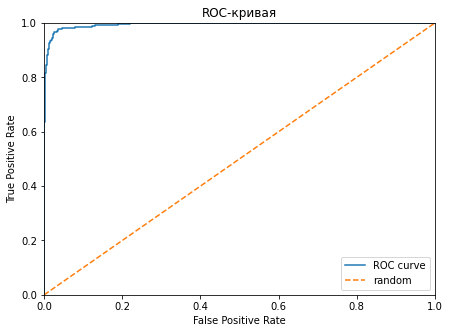

In [40]:
probabilities_test = best_model.predict_proba(features_test_bert)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test_bert, probabilities_one_test)
plt.figure()
plt.figure(figsize=[7,5])
plt.step(fpr,tpr,where='post', label='ROC curve')
plt.plot([0,1], [0,1], linestyle='--', label='random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

In [41]:
roc_auc = roc_auc_score(target_test_bert, probabilities_one_test)
print('Площадь под roc-кривой для модели LightGBM:', roc_auc)

Площадь под roc-кривой для модели LightGBM: 0.994508463186953


В хорошей модели порог отсечения ставит истинно положительные доли как можно ближе к 1, при этом сохраняя ложно положительные доли на самом нижнем из возможных уровней. Вывод: модель отлично справляется со своей задачей.

## Вывод

Цель была достигнута - метрика f1 для модели оценки тональности твитов более 0.90. <br>
В ходе работы над проектом была проведена очистка и лемматизация текста. Из большого набора данных выбраны 10 000 строк для обучения и тестирования модели. <br>
Были рассмотрены два способа создания признаков: TF-IDF и токенизация с помощью toxicBERT. <br>
Также в ходе обучения использовались разные модели, среди которых *LightGBM*, логистическая регрессия и наивный баессовский классификатор. Лучший результат показала *LightGBM* - f1 = 0.91 на тестовой выборке.